In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rajeev.maram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rajeev.maram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [286]:
df = pd.read_csv('spam.csv', names=['label', 'message'])

In [247]:
spam=pd.read_csv('spam.csv')

In [287]:
df

label message
v1   v2                                                 NaN   NaN     NaN
ham  Go until jurong point, crazy.. Available only i... NaN   NaN     NaN
     Ok lar... Joking wif u oni...                      NaN   NaN     NaN
spam Free entry in 2 a wkly comp to win FA Cup final... NaN   NaN     NaN
ham  U dun say so early hor... U c already then say...  NaN   NaN     NaN
...                                                           ...     ...
spam This is the 2nd time we have tried 2 contact u.... NaN   NaN     NaN
ham  Will Ã_ b going to esplanade fr home?              NaN   NaN     NaN
     Pity, * was in mood for that. So...any other su... NaN   NaN     NaN
     The guy did some bitching but I acted like i'd ... NaN   NaN     NaN
     Rofl. Its true to its name                         NaN   NaN     NaN

[5573 rows x 2 columns]

In [249]:
#dropping wrongly created columns and renaming
spam=spam.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
spam=spam.rename(columns={'v1':'label','v2':'message'})

In [283]:
spam.message[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [251]:
spam.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [252]:
#replacing the label values with 0 and 1
spam['label']=spam['label'].replace({'spam':1,'ham':0})

In [253]:
spam.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [254]:
spam.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        4825   4516                             Sorry, I'll call later   30
1         747    653  Please call our customer service representativ...    4

total class of 1 and 0: 1    4825
0    4825
Name: label, dtype: int64


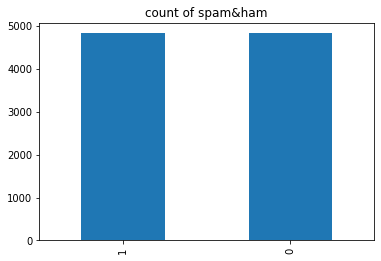

In [255]:
#handling the imbalanced dataset with random oversampling
#seperating the classes
class_0 = spam[spam['label'] == 0]
class_1 = spam[spam['label'] == 1]

class_count_0, class_count_1 = spam['label'].value_counts() #count of 0's and 1's
class_1_over = class_1.sample(class_count_0, replace=True) #oversampling of class 1
spam_balanced = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",spam_balanced['label'].value_counts())
spam_balanced['label'].value_counts().plot(kind='bar', title='count of spam&ham')

In [256]:
#sorting and reseting the index after random sampling
spam_balanced=spam_balanced.sort_index()
spam_balanced=spam_balanced.reset_index()
spam_balanced=spam_balanced.drop(['index'],axis=1)

In [257]:
#Feature engineering
spam_balanced['word_count']=spam_balanced['message'].str.split().str.len()

In [258]:
#counting the number of words in each message
spam_balanced.head()

,label,message,word_count
0,0,"Go until jurong point, crazy.. Available only ...",20
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,1,Free entry in 2 a wkly comp to win FA Cup fina...,28
4,1,Free entry in 2 a wkly comp to win FA Cup fina...,28


In [259]:
# checking if the message have any currency symbols because they are most likely to be spam (scam)
def currency(x):
    Symbols= ['$','€','¥', '£', '₹']
    for i in Symbols:
        if i in x:
            return 1
    return 0
spam_balanced['contains_currency_symbol'] = spam_balanced['message'].apply(currency)   

In [260]:
spam_balanced.groupby('contains_currency_symbol').describe()

label                                               \
                           count      mean       std  min  25%  50%  75%  max   
contains_currency_symbol                                                        
0                         7922.0  0.399268  0.489779  0.0  0.0  0.0  1.0  1.0   
1                         1728.0  0.961806  0.191721  0.0  1.0  1.0  1.0  1.0   

                         word_count                                         \
                              count       mean        std  min   25%   50%   
contains_currency_symbol                                                     
0                            7922.0  17.795001  10.693354  1.0   8.0  17.0   
1                            1728.0  24.885995   4.746043  5.0  23.0  26.0   

                                       
                           75%    max  
contains_currency_symbol               
0                         26.0  171.0  
1                         27.0   98.0

In [261]:
#Data cleaning 
corpus = []
wnl = WordNetLemmatizer()

for sms_string in list(spam_balanced.message):
    message = re.sub('[^a-zA-Z]', ' ', string=sms_string) #Replacing all non-alphabetic characters with a space
    message = message.lower() #c(onverting to lowercase
    words = message.split() #splitting message into words
    filtered_words = [word for word in words if word not in stopwords.words('english')] # removing stop words
    lemmatized_words = [wnl.lemmatize(word) for word in filtered_words] #lemmatize the words
    message = ' '.join(lemmatized_words) #joining the lemmatized words
    corpus.append(message) #building corpus of messages

In [263]:
# Creating the Bag of Words model
tfidf = TfidfVectorizer(max_features=500)

vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names()

# Extracting independent and dependent variables from the dataset
X = pd.DataFrame(vectors, columns=feature_names)
y = spam_balanced['label']

In [272]:
#splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [277]:
# Fitting Random Forest to the Training set
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10)
cv = cross_val_score(rf, X, y, scoring='f1', cv=10)
print('--- Average F1-Score for Random Forest model: {} ---'.format(round(cv.mean(), 3)))
print('Standard Deviation: {}'.format(round(cv.std(), 3)))

--- Average F1-Score for Random Forest model: 0.941 ---
Standard Deviation: 0.019


In [278]:
# Classification report for Random Forest model
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [280]:
#pickling this model
import pickle
file=open('rf_model.pkl','wb')

pickle.dump(rf,file)